# Lane Detection, segmentation and classification using Cascaded CNNs and LCNet, ERNet models

***With Updated extract_descriptors***



In [ ]:
import torch
import torchvision
import numpy as np
import random
import math

# Data loading and visualization imports
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage
from matplotlib.pyplot import imshow, figure, subplots

# Model loading
from models.erfnet import Net as ERFNet
from models.lcnet import Net as LCNet

# utils
from functions import color_lanes, blend

# to cuda or not to cuda
if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location='cpu'


Break down of the step1 code:

### Import Statements:
1. **Torch and Torchvision**:
   ```python
   import torch
   import torchvision
   ```
   - `torch` is the core PyTorch library used for tensor operations and neural network implementations.
   - `torchvision` is an extension library that includes popular datasets, model architectures, and image transformations for computer vision tasks.

2. **Additional Libraries**:
   ```python
   import numpy as np
   import random
   import math
   ```
   - `numpy` is a library for numerical operations.
   - `random` is a module for generating random numbers.
   - `math` is a module for mathematical functions.

3. **Data Loading and Visualization**:
   ```python
   from PIL import Image
   from torchvision.transforms import ToTensor, ToPILImage
   from matplotlib.pyplot import imshow, figure, subplots
   ```
   - `PIL` (Python Imaging Library) is used for image processing.
   - `ToTensor` converts a PIL Image or numpy array to a PyTorch tensor.
   - `ToPILImage` converts a tensor to a PIL Image.
   - `matplotlib.pyplot` functions (`imshow`, `figure`, `subplots`) are used for visualizing images.

4. **Model Loading**:
   ```python
   from models.erfnet import Net as ERFNet
   from models.lcnet import Net as LCNet
   ```
   - These lines import the `Net` classes from `erfnet` and `lcnet` modules, which are presumably defined in `models`. They are renamed to `ERFNet` and `LCNet` respectively for easier reference.

5. **Utility Functions**:
   ```python
   from functions import color_lanes, blend
   ```
   - `color_lanes` and `blend` are utility functions imported from the `functions` module. These functions are likely used for processing and visualizing lane detection results.

### CUDA Configuration:
6. **Determine Device for Computation**:
   ```python
   if torch.cuda.is_available():
       map_location=lambda storage, loc: storage.cuda()
   else:
       map_location='cpu'
   ```
   - This section checks if a CUDA-enabled GPU is available.
   - If a GPU is available, `map_location` is set to move storage to CUDA (GPU).
   - If no GPU is available, `map_location` is set to use the CPU.

### Summary:
- The code sets up the environment for lane detection using PyTorch and torchvision.
- It imports necessary libraries for data loading, visualization, and model loading.
- It checks the availability of a CUDA-enabled GPU to decide whether to use GPU or CPU for computations.
  
This setup is essential for performing tasks like image loading and preprocessing, model inference, and visualizing lane detection results.

In [ ]:
# Descriptor size definition
DESCRIPTOR_SIZE = 16

# Maximum number of lanes the network has been trained with + background
NUM_CLASSES_SEGMENTATION = 5

# Maxmimum number of classes for classification
NUM_CLASSES_CLASSIFICATION = 3

# Image size
HEIGHT = 360
WIDTH = 640

break down of step 2 code:

### Descriptor Size Definition:
```python
DESCRIPTOR_SIZE = 16
```
- **Descriptor Size**: This line sets the size of the descriptor to 16. Descriptors are small, fixed-size patches or features extracted from the image, typically used in tasks like lane detection or object recognition to represent the image data efficiently.

### Number of Classes for Segmentation:
```python
NUM_CLASSES_SEGMENTATION = 5
```
- **Number of Classes for Segmentation**: This line defines the maximum number of lane classes the segmentation network has been trained to detect, plus the background class. Here, the network can detect up to 4 different lane classes, and an additional class for the background, making a total of 5 classes.

### Number of Classes for Classification:
```python
NUM_CLASSES_CLASSIFICATION = 3
```
- **Number of Classes for Classification**: This line sets the maximum number of classes for the classification task to 3. This could be used for classifying different types of lanes, road markings, or other relevant categories.

### Image Size:
```python
HEIGHT = 360
WIDTH = 640
```
- **Image Size**: These lines define the height and width of the input images. The images will be resized to 360 pixels in height and 640 pixels in width before being fed into the network. This ensures consistency in the input size, which is crucial for the neural network to process the images correctly.

### Summary:
- `DESCRIPTOR_SIZE = 16`: Defines the size of feature descriptors.
- `NUM_CLASSES_SEGMENTATION = 5`: Specifies the total number of segmentation classes, including the background.
- `NUM_CLASSES_CLASSIFICATION = 3`: Indicates the number of classes for classification tasks.
- `HEIGHT = 360`, `WIDTH = 640`: Sets the dimensions for the input images.

In [ ]:
import os
from PIL import Image

def open_images_from_directory(directory_path):
    # List to store opened images
    images = []

    # Iterate through all files in the directory
    for filename in os.listdir(directory_path):
        # Create the full file path
        file_path = os.path.join(directory_path, filename)

        # Check if it's an image file (you can add more extensions if needed)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
            # Open and append the image to the list
            img = Image.open(file_path)
            images.append(img)

    return images

# Usage example
directory_path = '/content/images/'
images = open_images_from_directory(directory_path)
# Print the number of images opened
print(f'Number of images opened: {len(images)}')


Number of images opened: 10


**Step 3 code desc:**

### Import Statements
1. **Importing Libraries**:
   ```python
   import os
   from PIL import Image
   ```
   - `os`: This module provides a way of using operating system-dependent functionality like reading or writing to the file system.
   - `Image` from `PIL` (Python Imaging Library): This is used for opening and manipulating image files.

### Function Definition
2. **Defining the Function**:
   ```python
   def open_images_from_directory(directory_path):
       # List to store opened images
       images = []

       # Iterate through all files in the directory
       for filename in os.listdir(directory_path):
           # Create the full file path
           file_path = os.path.join(directory_path, filename)

           # Check if it's an image file (you can add more extensions if needed)
           if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
               # Open and append the image to the list
               img = Image.open(file_path)
               images.append(img)

       return images
   ```
   - **Function Name**: `open_images_from_directory(directory_path)`
     - This function takes a directory path as input and returns a list of opened images.
   - **List Initialization**: `images = []`
     - Initializes an empty list to store the opened images.
   - **Iterating through the Directory**: `for filename in os.listdir(directory_path):`
     - Iterates over all files in the specified directory.
   - **Creating Full File Path**: `file_path = os.path.join(directory_path, filename)`
     - Constructs the full file path for each file in the directory.
   - **Checking File Extension**: `if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):`
     - Checks if the file is an image based on its extension (case-insensitive).
   - **Opening and Appending Images**: `img = Image.open(file_path)`
     - Opens the image file.
     - `images.append(img)`: Appends the opened image to the `images` list.
   - **Return Statement**: `return images`
     - Returns the list of opened images.

### Calling function for images in directory
3. **Calling function **:
   ```python
   # Calling of function
   directory_path = '/content/images/'
   images = open_images_from_directory(directory_path)
   # Print the number of images opened
   print(f'Number of images opened: {len(images)}')
   ```
   - **Directory Path**: `directory_path = '/content/images/'`
     - Specifies the path to the directory containing the images.
   - **Calling the Function**: `images = open_images_from_directory(directory_path)`
     - Calls the function with the specified directory path and stores the returned list of images in the `images` variable.
   - **Printing the Result**: `print(f'Number of images opened: {len(images)}')`
     - Prints the number of images that were successfully opened.

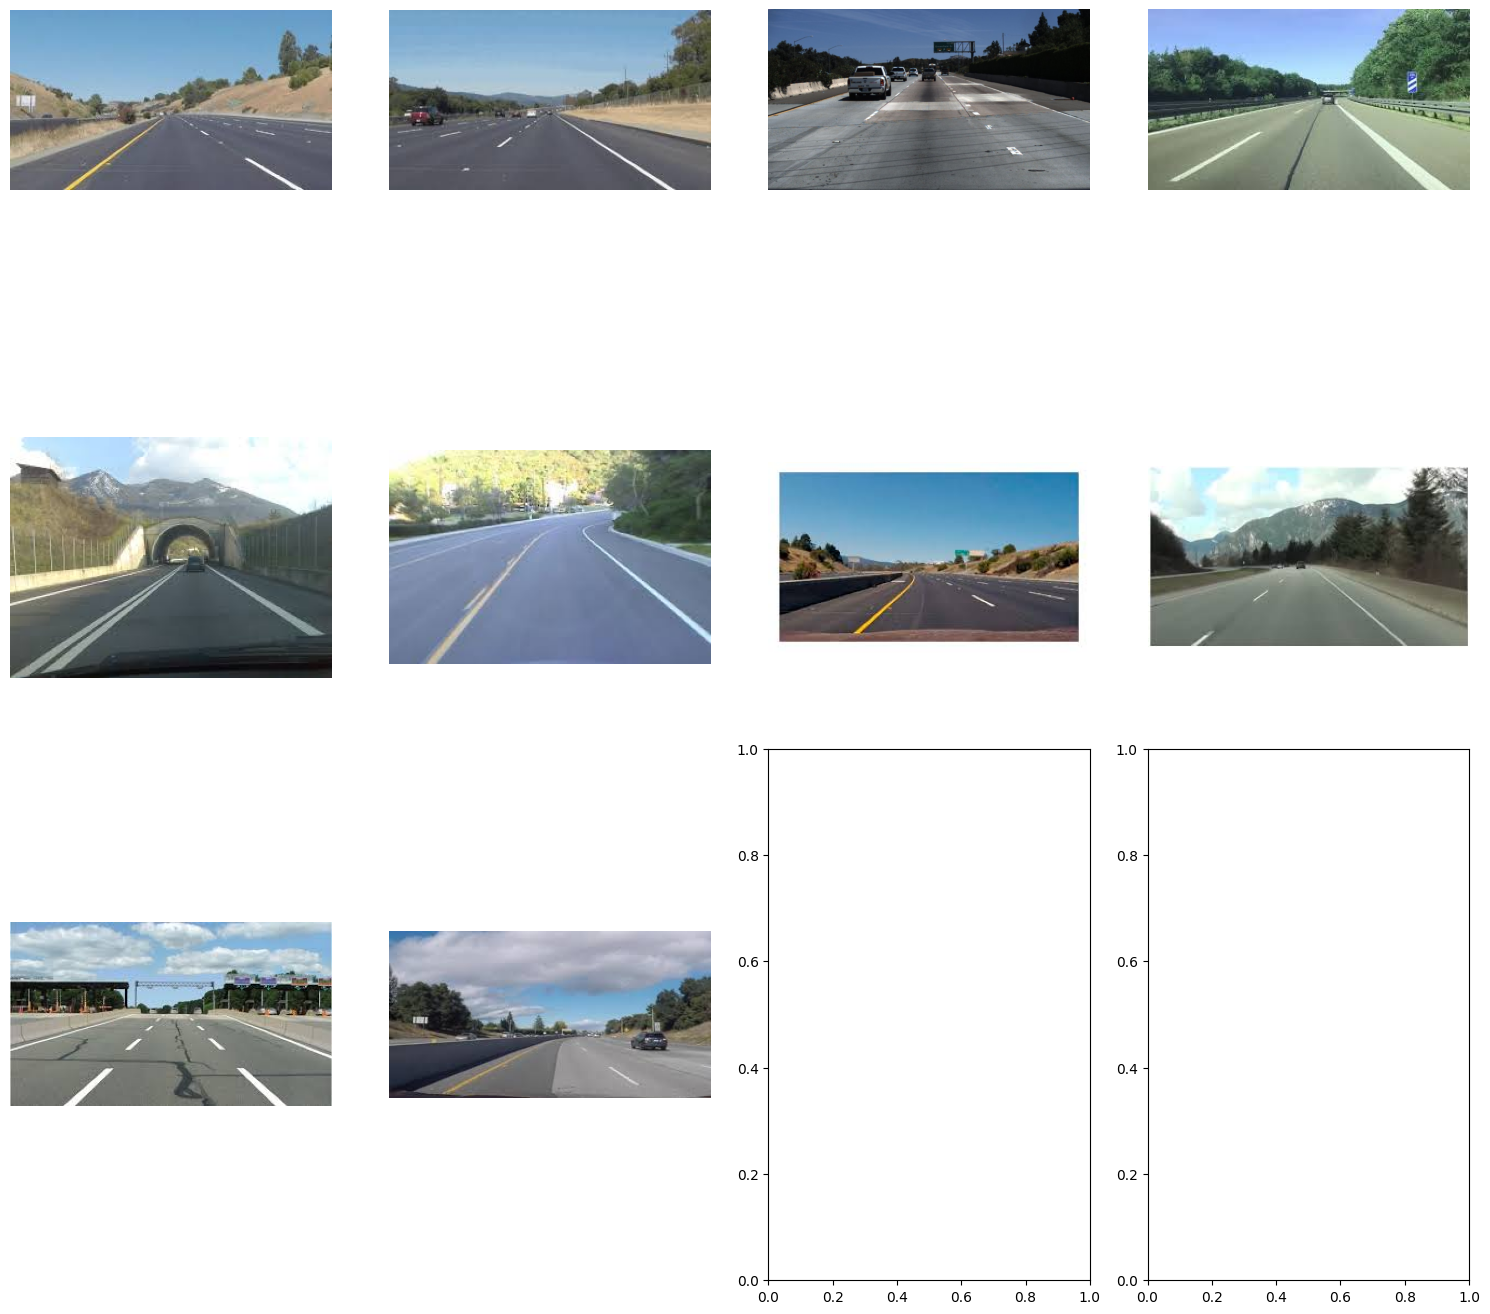

In [ ]:
# prompt: show images loaded in previous step

import matplotlib.pyplot as plt

def show_images(images):
    # Calculate the number of rows and columns for the subplots
    num_images = len(images)
    cols = min(num_images, 4)  # Adjust the number of columns as needed
    rows = math.ceil(num_images / cols)

    # Create the subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))

    # Iterate through the images and display them in the subplots
    for i, img in enumerate(images):
        row = i // cols
        col = i % cols

        if rows > 1:
          axes[row, col].imshow(img)
          axes[row, col].axis('off')
        else:
          axes[col].imshow(img)
          axes[col].axis('off')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

# Assuming 'images' is the list of images
if 'images' in locals() and images:  # Check if images variable exists and is not empty
    show_images(images)
else:
    print("No images found to display. Make sure you have run the code that loads the images first.")

In [ ]:
import os
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor

def process_images_from_directory(directory_path, width, height):
    # List to store the processed tensors
    tensors = []

    # Iterate through all files in the directory
    for filename in os.listdir(directory_path):
        # Create the full file path
        file_path = os.path.join(directory_path, filename)

        # Check if it's an image file (you can add more extensions if needed)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
            # Open the image
            im = Image.open(file_path)

            # Resize the image
            im = im.resize((width, height))

            # Display the image
            plt.imshow(im)
            plt.title(f'{filename}')
            plt.show()

            # Convert the image to a tensor
            im_tensor = ToTensor()(im)

            # Add a batch dimension
            im_tensor = im_tensor.unsqueeze(0)

            # Append the tensor to the list
            tensors.append(im_tensor)

            # Print the shape of the tensor
            print(f'Shape of {filename} tensor:', im_tensor.shape)

    return tensors

# Usage example
directory_path = '/content/images/'  # Specify the directory path
WIDTH, HEIGHT = 640, 360  # Define the desired dimensions

# Process the images
tensors = process_images_from_directory(directory_path, WIDTH, HEIGHT)

# Print the number of processed tensors
print(f'Number of processed tensors: {len(tensors)}')



### Explanation:
1. **Import Libraries**: Import the necessary libraries for image processing (`PIL`), tensor conversion (`torchvision.transforms`), and displaying images (`matplotlib`).
2. **Define Function**: Create a function `process_images_from_directory` that takes the directory path and desired dimensions as input.
3. **Initialize List**: Initialize an empty list to store the processed tensors.
4. **Iterate Through Directory**: Use `os.listdir(directory_path)` to iterate through all files in the directory.
5. **Check File Extension**: Check if the file is an image by looking at its extension.
6. **Open and Resize Image**: Open the image using `Image.open(file_path)` and resize it to the specified dimensions.
7. **Display Image**: Display the image using `plt.imshow(im)`.
8. **Convert to Tensor**: Convert the image to a tensor with `ToTensor()(im)`.
9. **Add Batch Dimension**: Add a batch dimension with `im_tensor.unsqueeze(0)`.
10. **Append and Print Shape**: Append the tensor to the list and print the shape of the tensor.
11. **Return Tensors**: Return the list of processed tensors.

This script will help you load, process, display, and convert images from a directory to tensors, adding a batch dimension to each tensor and printing their shapes.

Now let's load the weights of the CNNs by using pytorch methods.

Shape of test3.jpg tensor: torch.Size([1, 3, 640, 360])
Shape of test8.jpg tensor: torch.Size([1, 3, 640, 360])
Shape of test.jpg tensor: torch.Size([1, 3, 640, 360])
Shape of test4.jpg tensor: torch.Size([1, 3, 640, 360])
Shape of test5.jpg tensor: torch.Size([1, 3, 640, 360])
Shape of test7.jpg tensor: torch.Size([1, 3, 640, 360])
Shape of test9.jpg tensor: torch.Size([1, 3, 640, 360])
Shape of test6.jpg tensor: torch.Size([1, 3, 640, 360])
Shape of test2.jpg tensor: torch.Size([1, 3, 640, 360])
Shape of test11.jpg tensor: torch.Size([1, 3, 640, 360])
Number of processed tensors: 10


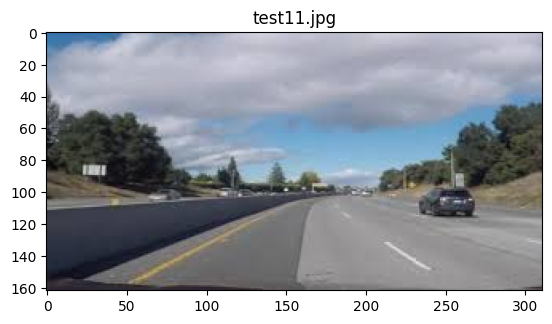

In [ ]:
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

def load_and_preprocess_images(directory_path, width, height):
    tensors = []
    transform = transforms.Compose([
        transforms.Resize((width, height)),
        transforms.ToTensor()
    ])

    for filename in os.listdir(directory_path):
        file_path = os.path.join(directory_path, filename)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
            im = Image.open(file_path).convert('RGB')
            im_resized = transform(im)

            plt.imshow(im)
            plt.title(f'{filename}')
            #plt.show()

            im_tensor = im_resized.unsqueeze(0)
            tensors.append(im_tensor)

            print(f'Shape of {filename} tensor:', im_tensor.shape)

    return tensors

# Call function
directory_path = '/content/images/'  # Specify the directory path
WIDTH, HEIGHT = 640, 360  # Define the desired dimensions

tensors = load_and_preprocess_images(directory_path, WIDTH, HEIGHT)
print(f'Number of processed tensors: {len(tensors)}')


We also need to load the weights of the CNNs. We simply load it using pytorch methods.

Shape of test3.jpg tensor: torch.Size([1, 3, 640, 360])
Shape of test8.jpg tensor: torch.Size([1, 3, 640, 360])
Shape of test.jpg tensor: torch.Size([1, 3, 640, 360])
Shape of test4.jpg tensor: torch.Size([1, 3, 640, 360])
Shape of test5.jpg tensor: torch.Size([1, 3, 640, 360])
Shape of test7.jpg tensor: torch.Size([1, 3, 640, 360])
Shape of test9.jpg tensor: torch.Size([1, 3, 640, 360])
Shape of test6.jpg tensor: torch.Size([1, 3, 640, 360])
Shape of test2.jpg tensor: torch.Size([1, 3, 640, 360])
Shape of test11.jpg tensor: torch.Size([1, 3, 640, 360])
Number of processed tensors: 10


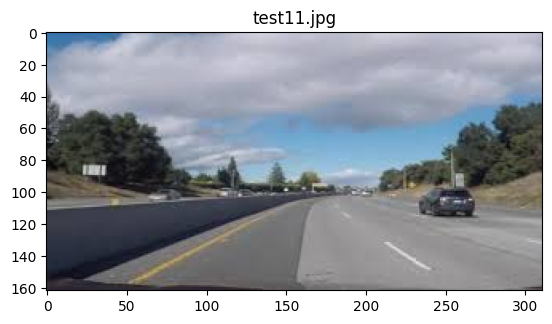

In [62]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.transforms import ToTensor, Resize

# Define the directory path
directory_path = 'images/'
WIDTH, HEIGHT = 640, 360  # Define the desired dimensions

def process_images_from_directory(directory_path, width, height):
    tensors = []
    transform = Resize((width, height))

    for filename in os.listdir(directory_path):
        file_path = os.path.join(directory_path, filename)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
            im = Image.open(file_path).convert('RGB')

            # Visualize the image
            plt.imshow(np.asarray(im))
            plt.title(f'{filename}')
            #plt.show()

            # Resize the image
            im = transform(im)

            # Convert the image to a tensor
            im_tensor = ToTensor()(im)

            # Add a batch dimension
            im_tensor = im_tensor.unsqueeze(0)
            tensors.append(im_tensor)

            # Print the shape of the tensor
            print(f'Shape of {filename} tensor:', im_tensor.shape)

    return tensors

# Usage example
tensors = process_images_from_directory(directory_path, WIDTH, HEIGHT)
print(f'Number of processed tensors: {len(tensors)}')


In [ ]:
# Creating CNNs and loading pretrained models
segmentation_network = ERFNet(NUM_CLASSES_SEGMENTATION)
classification_network = LCNet(NUM_CLASSES_CLASSIFICATION, DESCRIPTOR_SIZE, DESCRIPTOR_SIZE)

segmentation_network.load_state_dict(torch.load('/content/pretrained/erfnet_tusimple.pth', map_location = map_location))
model_path = '/content/pretrained/classification_{}_{}class.pth'.format(DESCRIPTOR_SIZE, NUM_CLASSES_CLASSIFICATION)
classification_network.load_state_dict(torch.load(model_path, map_location = map_location))

segmentation_network = segmentation_network.eval()
classification_network = classification_network.eval()

if torch.cuda.is_available():
    segmentation_network = segmentation_network.cuda()
    classification_network = classification_network.cuda()

<ipython-input-25-7dc58be948f3>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  segmentation_network.load_state_dict(torch.load('/content/pretrained/erfnet_tusimple.pth', m

**code desc step by step:**

### 1. Creating CNNs (Convolutional Neural Networks)
```python
segmentation_network = ERFNet(NUM_CLASSES_SEGMENTATION)
classification_network = LCNet(NUM_CLASSES_CLASSIFICATION, DESCRIPTOR_SIZE, DESCRIPTOR_SIZE)
```
- **segmentation_network**: This line creates an instance of the `ERFNet` model for segmentation tasks. The model is initialized with the number of segmentation classes (`NUM_CLASSES_SEGMENTATION`).
- **classification_network**: This line creates an instance of the `LCNet` model for classification tasks. The model is initialized with the number of classification classes (`NUM_CLASSES_CLASSIFICATION`) and descriptor sizes for height and width (`DESCRIPTOR_SIZE`).

### 2. Loading Pretrained Models
```python
segmentation_network.load_state_dict(torch.load('pretrained/erfnet_tusimple.pth', map_location = map_location))
model_path = 'pretrained/classification_{}_{}class.pth'.format(DESCRIPTOR_SIZE, NUM_CLASSES_CLASSIFICATION)
classification_network.load_state_dict(torch.load(model_path, map_location = map_location))
```
- **Load ERFNet Weights**: This line loads the pretrained weights for the `ERFNet` model from the file `pretrained/erfnet_tusimple.pth` and maps them to the appropriate device (`map_location`).
- **Define Model Path**: This line constructs the path to the pretrained weights for the `LCNet` model using the descriptor size and the number of classification classes.
- **Load LCNet Weights**: This line loads the pretrained weights for the `LCNet` model from the constructed file path and maps them to the appropriate device (`map_location`).

### 3. Setting Models to Evaluation Mode
```python
segmentation_network = segmentation_network.eval()
classification_network = classification_network.eval()
```
- These lines set both the `ERFNet` and `LCNet` models to evaluation mode. In this mode, certain layers like dropout and batch normalization work differently to ensure consistent inference results.

### 4. Moving Models to GPU if Available
```python
if torch.cuda.is_available():
    segmentation_network = segmentation_network.cuda()
    classification_network = classification_network.cuda()
```
- This condition checks if a CUDA-enabled GPU is available.
- If a GPU is available, both the `ERFNet` and `LCNet` models are moved to the GPU using the `.cuda()` method. This improves computation speed for inference tasks.


In [ ]:
# Access all the element (indexs) from tensors using loop and do below for all tensors
for im_tensor in tensors:
  if torch.cuda.is_available():
    im_tensor = im_tensor.cuda()
  out_segmentation = segmentation_network(im_tensor)
  out_segmentation = out_segmentation.max(dim=1)[1]

**code description step by step:**

### Loop Through Tensors
```python
for im_tensor in tensors:
```
- This line iterates through each image tensor in the list `tensors`. Each `im_tensor` represents a preprocessed image that has been converted to a tensor and potentially has a batch dimension.

### Move Tensor to GPU if Available
```python
if torch.cuda.is_available():
    im_tensor = im_tensor.cuda()
```
- This checks if a CUDA-enabled GPU is available.
- If a GPU is available, it moves the current image tensor (`im_tensor`) to the GPU for faster computation.

### Perform Segmentation Inference
```python
out_segmentation = segmentation_network(im_tensor)
```
- This forwards the image tensor through the `segmentation_network` (ERFNet), performing segmentation inference.
- The output, `out_segmentation`, contains the segmentation predictions for each pixel in the image.

### Extract Segmentation Map
```python
out_segmentation = out_segmentation.max(dim=1)[1]
```
- The `max(dim=1)` function is used to find the class with the highest probability for each pixel across all segmentation classes.
- `dim=1` indicates that the function is applied across the class dimension.
- `[1]` extracts the indices of the maximum values, representing the predicted class for each pixel.
- `out_segmentation` now contains the final segmentation map, where each pixel is labeled with the predicted class.

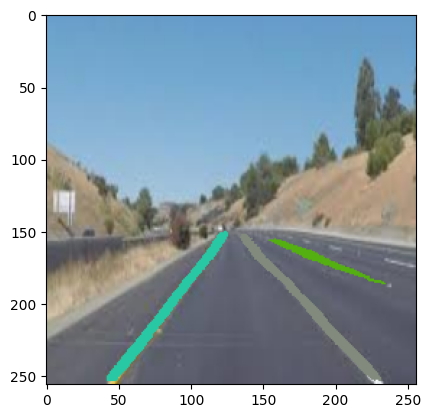

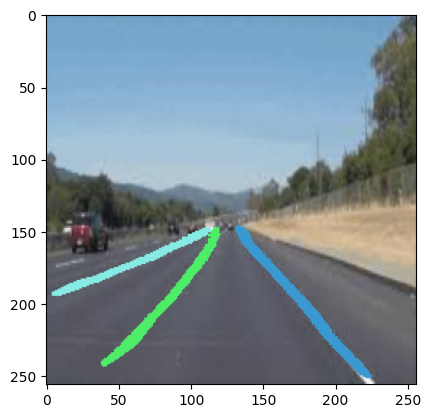

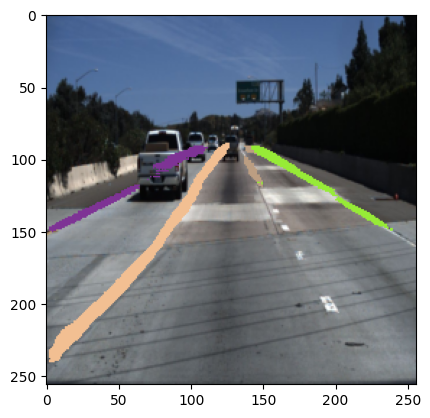

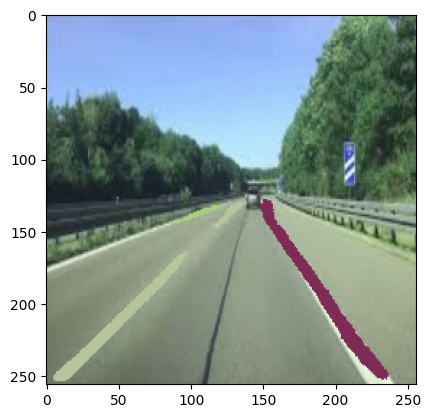

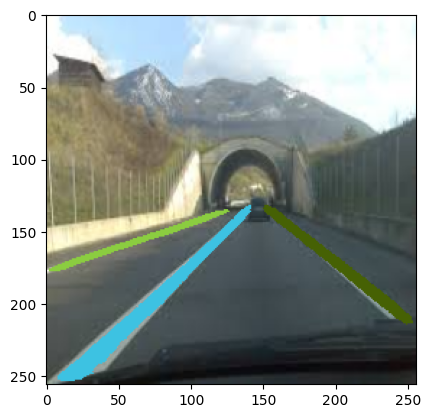

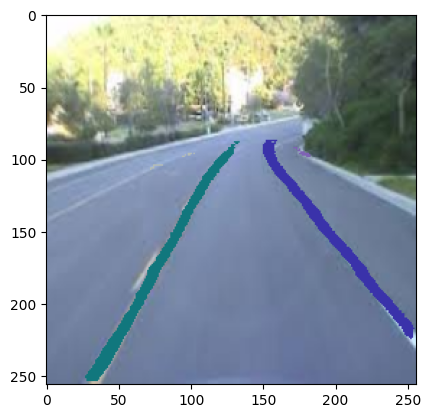

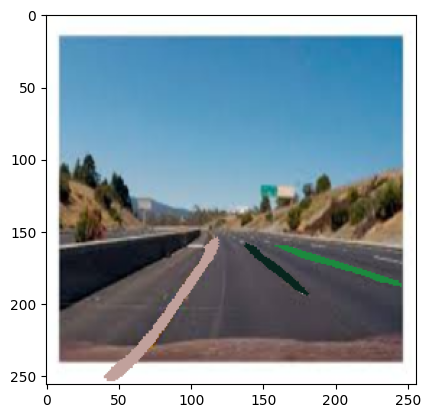

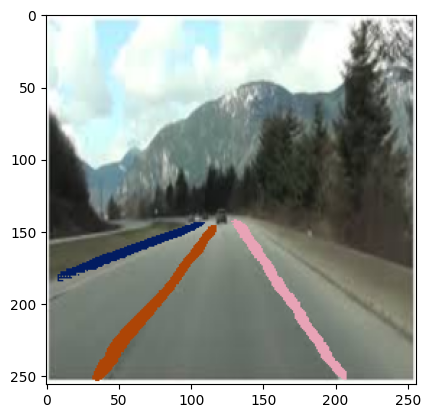

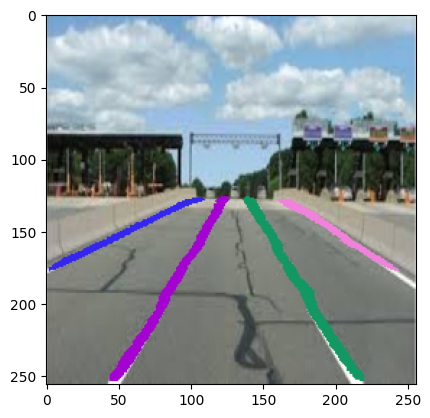

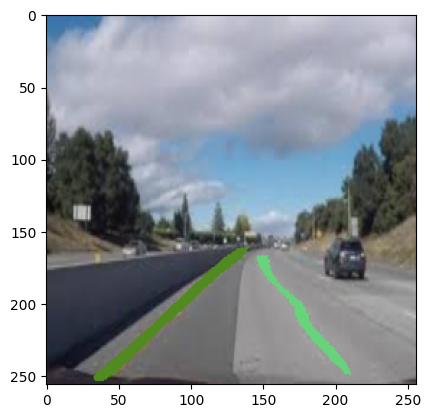

In [ ]:
import torch
import torchvision
import numpy as np
import random
import math
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage
from matplotlib.pyplot import imshow, figure, subplots
from models.erfnet import Net as ERFNet
from models.lcnet import Net as LCNet
from functions import color_lanes, blend
import os
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, Resize


for im_tensor in tensors:
    if torch.cuda.is_available():
        im_tensor = im_tensor.cuda()
    out_segmentation = segmentation_network(im_tensor)
    out_segmentation = out_segmentation.max(dim=1)[1]

    # Converting to numpy for visualization
    out_segmentation_np = out_segmentation.cpu().numpy()[0]
    out_segmentation_viz = np.zeros((HEIGHT, WIDTH, 4))

    for i in range(1, NUM_CLASSES_SEGMENTATION):
        rand_c1 = random.randint(1, 255)
        rand_c2 = random.randint(1, 255)
        rand_c3 = random.randint(1, 255)
        out_segmentation_viz = color_lanes(
            out_segmentation_viz, out_segmentation_np,
            i, (rand_c1, rand_c2, rand_c3), HEIGHT, WIDTH)

    # Blend with the corresponding image tensor
    im = ToPILImage()(im_tensor.cpu().squeeze(0))
    im_seg = blend(im, out_segmentation_viz)
    imshow(np.asarray(im_seg))
    plt.show() #show each blended image

In [ ]:
def extract_descriptors(label, image):
    # avoids problems in the sampling
    eps = 0.01

    # The labels indices are not contiguous e.g. we can have index 1, 2, and 4 in an image
    # For this reason, we should construct the descriptor array sequentially
    inputs = torch.zeros(0, 3, DESCRIPTOR_SIZE, DESCRIPTOR_SIZE)
    if torch.cuda.is_available():
        inputs = inputs.cuda()

    # This is needed to keep track of the lane we are classifying
    mapper = {}
    classifier_index = 0

    # Iterating over all the possible lanes ids
    for i in range(1, NUM_CLASSES_SEGMENTATION):
        # This extracts all the points belonging to a lane with id = i
        single_lane = label.eq(i).view(-1).nonzero().squeeze()

        # As they could be not continuous, skip the ones that have no points
        if single_lane.numel() == 0 or len(single_lane.size()) == 0:
            continue

        # Points to sample to fill a squared desciptor
        sample = torch.zeros(DESCRIPTOR_SIZE * DESCRIPTOR_SIZE)
        if torch.cuda.is_available():
            sample = sample.cuda()

        sample = sample.uniform_(0, single_lane.size()[0] - eps).long()
        sample, _ = sample.sort()

        # These are the points of the lane to select
        points = torch.index_select(single_lane, 0, sample)

        # First, we view the image as a set of ordered points
        descriptor = image.squeeze().view(3, -1)

        # Then we select only the previously extracted values
        descriptor = torch.index_select(descriptor, 1, points)

        # Reshape to get the actual image
        descriptor = descriptor.view(3, DESCRIPTOR_SIZE, DESCRIPTOR_SIZE)
        descriptor = descriptor.unsqueeze(0)

        # Concatenate to get a batch that can be processed from the other network
        inputs = torch.cat((inputs, descriptor), 0)

        # Track the indices
        mapper[classifier_index] = i
        classifier_index += 1

    return inputs, mapper
descriptors, index_map = extract_descriptors(out_segmentation, im_tensor)

step by step desc: The `extract_descriptors` function aims to extract feature descriptors from an image based on its segmentation labels. Here’s a detailed explanation:

### Function Definition
```python
def extract_descriptors(label, image):
```
- **Function Name**: `extract_descriptors`
  - This function extracts feature descriptors from the input image.
- **Parameters**:
  - `label`: A segmentation label tensor where each pixel value corresponds to a specific class (e.g., different lanes in lane detection).
  - `image`: The input image tensor from which descriptors are to be extracted.

### Inside the Function
#### Initial Setup
```python
eps = 0.01
inputs = torch.zeros(0, 3, DESCRIPTOR_SIZE, DESCRIPTOR_SIZE)
if torch.cuda.is_available():
    inputs = inputs.cuda()
mapper = {}
classifier_index = 0
```
- **`eps`**: A small value to avoid problems during sampling.
- **`inputs`**: An empty tensor to store the extracted descriptors. It has a shape of `(0, 3, DESCRIPTOR_SIZE, DESCRIPTOR_SIZE)`, where `0` indicates the initial size of the batch dimension.
  - If a CUDA-enabled GPU is available, it moves the tensor to the GPU.
- **`mapper`**: A dictionary to keep track of the lane being classified.
- **`classifier_index`**: An index to keep track of the current classifier.

#### Iterate Over Possible Lane IDs
```python
for i in range(1, NUM_CLASSES_SEGMENTATION):
    single_lane = label.eq(i).view(-1).nonzero().squeeze()
```
- This loop iterates over each possible lane ID (from 1 to `NUM_CLASSES_SEGMENTATION - 1`).
- **`single_lane`**: Finds all points in the label tensor that belong to the current lane ID `i`.

#### Skip Empty Classes
```python
if single_lane.numel() == 0 or len(single_lane.size()) == 0:
    continue
```
- If there are no points for the current lane ID (`single_lane` is empty), the function skips to the next iteration.

#### Sampling Points
```python
sample = torch.zeros(DESCRIPTOR_SIZE * DESCRIPTOR_SIZE)
if torch.cuda.is_available():
    sample = sample.cuda()
sample = sample.uniform_(0, single_lane.size()[0] - eps).long()
sample, _ = sample.sort()
points = torch.index_select(single_lane, 0, sample)
```
- **`sample`**: Creates a tensor to store sampled points.
  - If a GPU is available, moves the tensor to the GPU.
- **`sample.uniform_`**: Samples points uniformly from the range `[0, single_lane.size()[0] - eps]`.
- **`points`**: Selects points from `single_lane` using the sampled indices.

#### Extracting and Reshaping Descriptors
```python
descriptor = image.squeeze().view(3, -1)
descriptor = torch.index_select(descriptor, 1, points)
descriptor = descriptor.view(3, DESCRIPTOR_SIZE, DESCRIPTOR_SIZE)
descriptor = descriptor.unsqueeze(0)
```
- **`descriptor`**: Views the image as a set of ordered points and selects the previously sampled points.
- **`descriptor.view`**: Reshapes the selected points to form a patch of size `(3, DESCRIPTOR_SIZE, DESCRIPTOR_SIZE)`.
- **`descriptor.unsqueeze(0)`**: Adds a batch dimension to the descriptor.

#### Concatenating Descriptors and Mapping Indices
```python
inputs = torch.cat((inputs, descriptor), 0)
mapper[classifier_index] = i
classifier_index += 1
```
- **`inputs`**: Concatenates the newly extracted descriptor to the `inputs` tensor.
- **`mapper`**: Tracks the index-to-class mapping for the current classifier.

### Return Statement
```python
return inputs, mapper
```
- Returns the batch of descriptors (`inputs`) and the mapping dictionary (`mapper`).

In [ ]:
# extract_descriptors(label, image) to take more than one images and more than one label

def extract_descriptors(labels, images):
    """
    Extracts descriptors from multiple images and their corresponding segmentation labels.

    Args:
        labels: A list of segmentation label tensors.
        images: A list of image tensors.

    Returns:
        A tuple containing:
            - descriptors: A list of descriptor tensors, one for each image.
            - mappers: A list of mapper dictionaries, one for each image.
    """

    all_descriptors = []
    all_mappers = []

    for label, image in zip(labels, images):
        # avoids problems in the sampling
        eps = 0.01

        inputs = torch.zeros(0, 3, DESCRIPTOR_SIZE, DESCRIPTOR_SIZE)
        if torch.cuda.is_available():
            inputs = inputs.cuda()

        mapper = {}
        classifier_index = 0

        for i in range(1, NUM_CLASSES_SEGMENTATION):
            single_lane = label.eq(i).view(-1).nonzero().squeeze()

            if single_lane.numel() == 0 or len(single_lane.size()) == 0:
                continue

            sample = torch.zeros(DESCRIPTOR_SIZE * DESCRIPTOR_SIZE)
            if torch.cuda.is_available():
                sample = sample.cuda()

            sample = sample.uniform_(0, single_lane.size()[0] - eps).long()
            sample, _ = sample.sort()

            points = torch.index_select(single_lane, 0, sample)

            descriptor = image.squeeze().view(3, -1)
            descriptor = torch.index_select(descriptor, 1, points)
            descriptor = descriptor.view(3, DESCRIPTOR_SIZE, DESCRIPTOR_SIZE)
            descriptor = descriptor.unsqueeze(0)

            inputs = torch.cat((inputs, descriptor), 0)

            mapper[classifier_index] = i
            classifier_index += 1

        all_descriptors.append(inputs)
        all_mappers.append(mapper)

    return all_descriptors, all_mappers

visualizing the descriptors. As you can see, some sort of pattern is easily recognizable. This is the information that the second CNN has learnt to recognize.

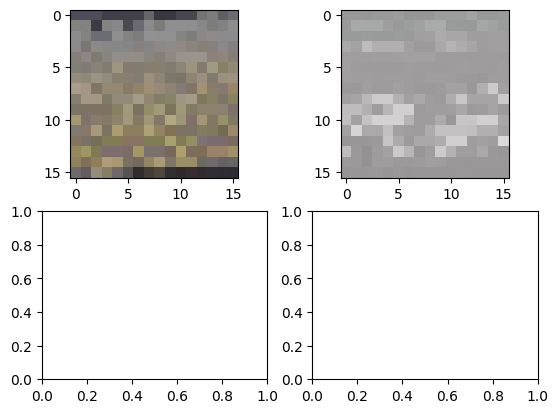

In [ ]:
GRID_SIZE = 2
_, fig = subplots(GRID_SIZE, GRID_SIZE)

for i in range(0, descriptors.size(0)):
    desc = descriptors[i].cpu()

    desc = ToPILImage()(desc)
    row = math.floor((i / GRID_SIZE))
    col = i % GRID_SIZE

    fig[row, col].imshow(np.asarray(desc))

Shape of test3.jpg tensor: torch.Size([1, 3, 640, 360])
Shape of test8.jpg tensor: torch.Size([1, 3, 640, 360])
Shape of test.jpg tensor: torch.Size([1, 3, 640, 360])
Shape of test4.jpg tensor: torch.Size([1, 3, 640, 360])
Shape of test5.jpg tensor: torch.Size([1, 3, 640, 360])
Shape of test7.jpg tensor: torch.Size([1, 3, 640, 360])
Shape of test9.jpg tensor: torch.Size([1, 3, 640, 360])
Shape of test6.jpg tensor: torch.Size([1, 3, 640, 360])
Shape of test2.jpg tensor: torch.Size([1, 3, 640, 360])
Shape of test11.jpg tensor: torch.Size([1, 3, 640, 360])
Number of processed tensors: 10


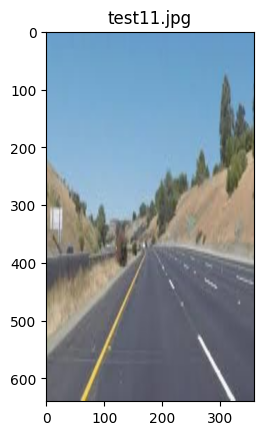

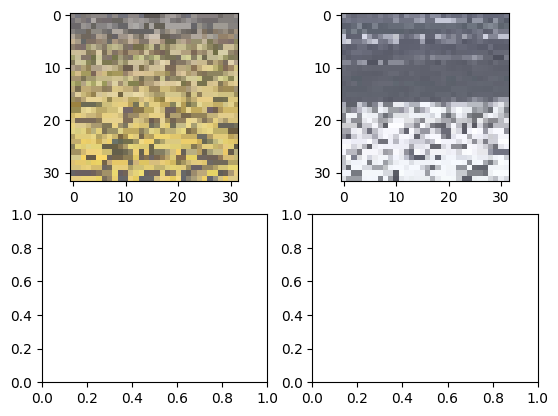

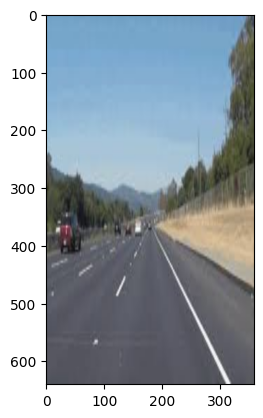

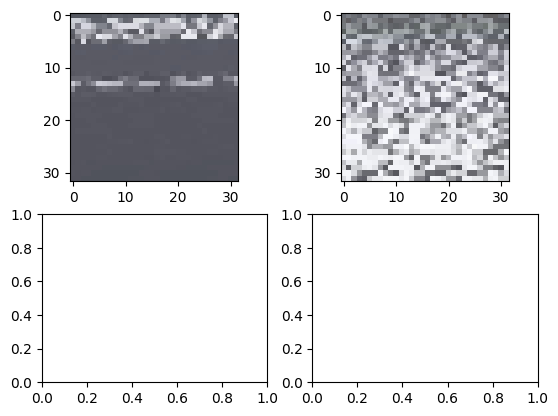

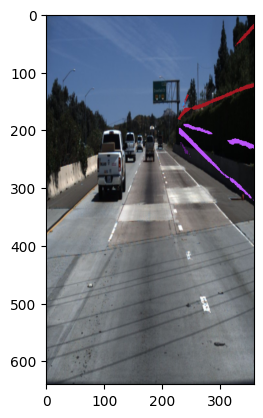

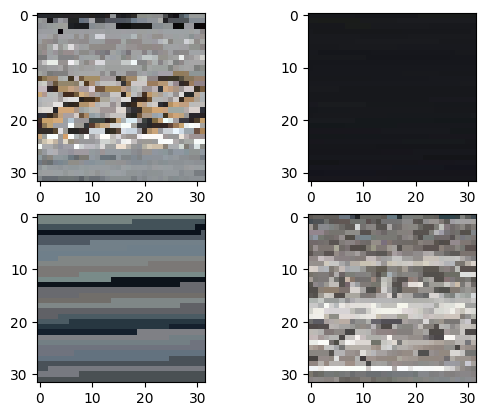

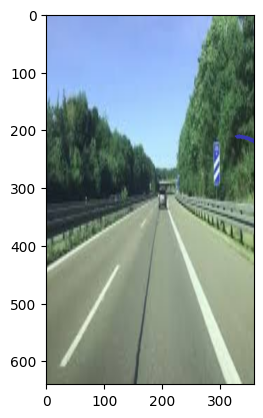

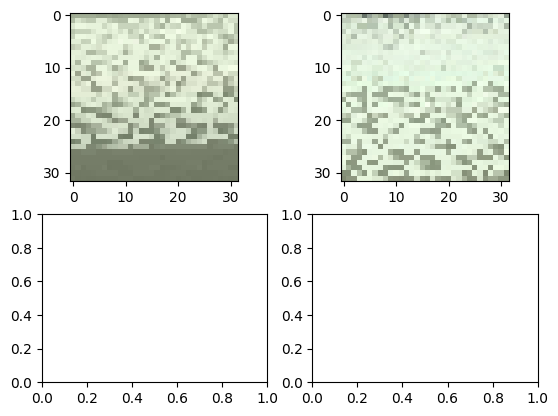

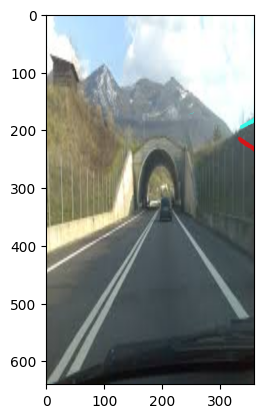

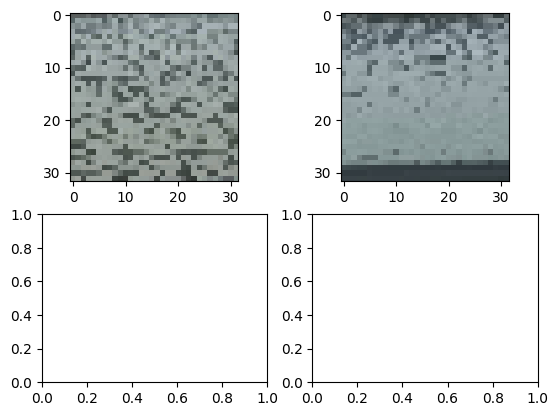

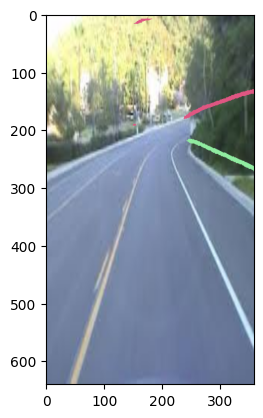

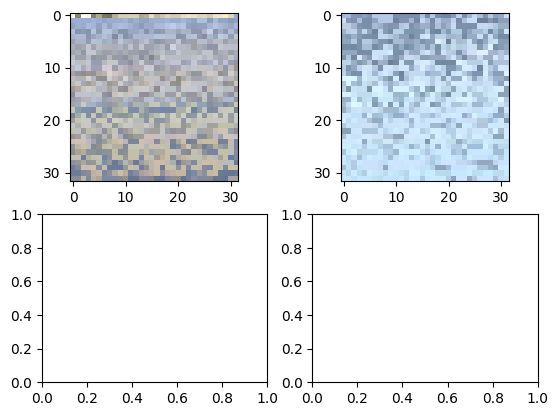

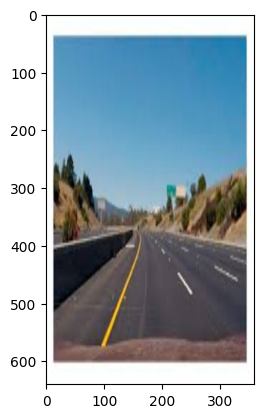

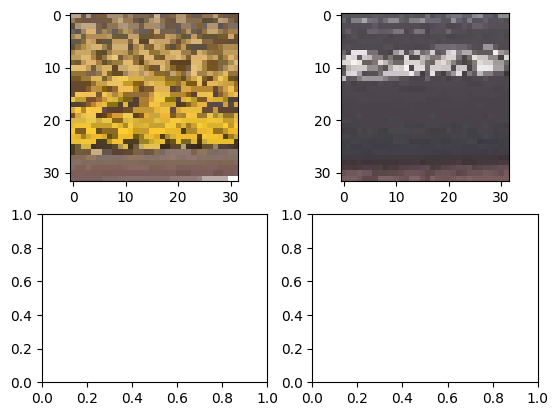

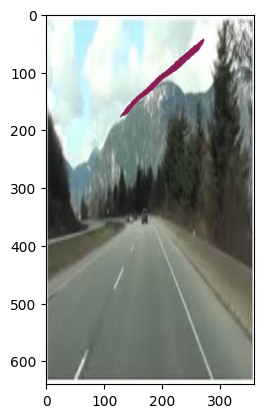

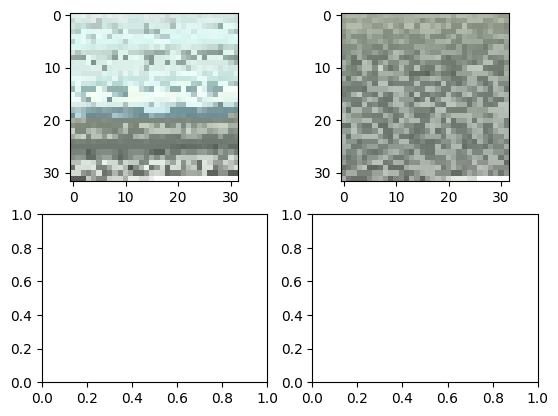

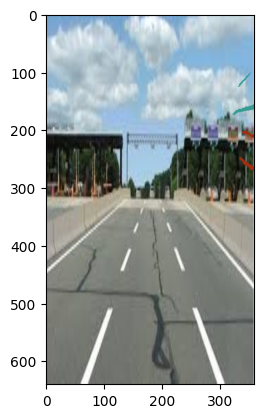

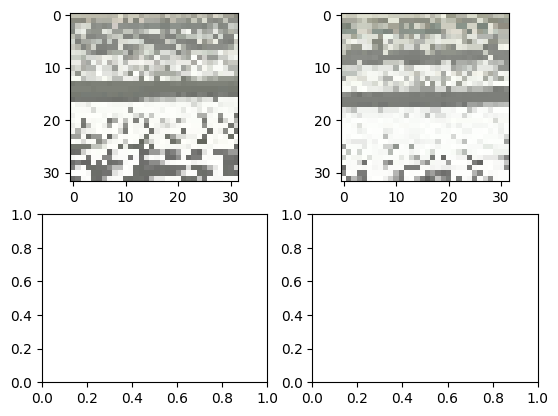

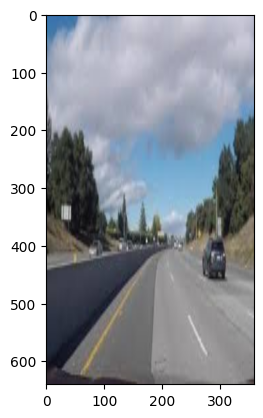

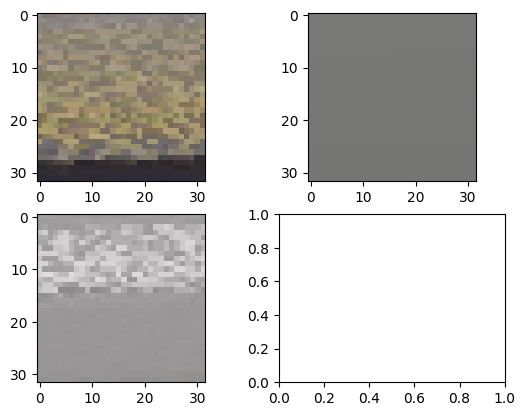

In [ ]:
#  process multiple images and tensors

import torch
import torchvision
import numpy as np
import random
import math
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage, Resize
from matplotlib.pyplot import imshow, figure, subplots
# Assuming erfnet and lcnet are defined elsewhere or imported correctly
# from models.erfnet import Net as ERFNet
# from models.lcnet import Net as LCNet
# from functions import color_lanes, blend  # Assuming these functions are defined
import os
import matplotlib.pyplot as plt
import torchvision.transforms as transforms


# ... (rest of the code, including functions like open_images_from_directory, etc.)


# Example Usage with multiple tensors

directory_path = '/content/images/'  # Replace with your image directory
WIDTH, HEIGHT = 640, 360  # Define the desired dimensions

# Process the images
tensors = load_and_preprocess_images(directory_path, WIDTH, HEIGHT)
print(f'Number of processed tensors: {len(tensors)}')

# Placeholder for NUM_CLASSES_SEGMENTATION, DESCRIPTOR_SIZE, NUM_CLASSES_CLASSIFICATION
NUM_CLASSES_SEGMENTATION = 6  # Replace with your actual value
DESCRIPTOR_SIZE = 32  # Replace with your actual value
NUM_CLASSES_CLASSIFICATION = 4 # Replace with your actual value


# Process each image tensor
all_segmentations = []
for im_tensor in tensors:
    if torch.cuda.is_available():
        im_tensor = im_tensor.cuda()
    with torch.no_grad(): #disable gradient calculation during inference for efficiency
        out_segmentation = segmentation_network(im_tensor)
        out_segmentation = out_segmentation.max(dim=1)[1]
    all_segmentations.append(out_segmentation)

# Visualization and descriptor extraction for multiple images
all_descriptors, all_mappers = extract_descriptors(all_segmentations, tensors)

for i in range(len(tensors)):
    # This line was incorrect - shape was (640, 360)
    # out_segmentation_np = all_segmentations[i].cpu().numpy()[0]

    # Reshape to correct dimensions (HEIGHT, WIDTH)
    out_segmentation_np = all_segmentations[i].cpu().numpy()[0].transpose(1, 0) #added to fix

    out_segmentation_viz = np.zeros((HEIGHT, WIDTH, 4))
    for j in range(1, NUM_CLASSES_SEGMENTATION):
        rand_c1 = random.randint(1, 255)
        rand_c2 = random.randint(1, 255)
        rand_c3 = random.randint(1, 255)
        out_segmentation_viz = color_lanes(
            out_segmentation_viz, out_segmentation_np,
            j, (rand_c1, rand_c2, rand_c3), HEIGHT, WIDTH
        )

    im = ToPILImage()(tensors[i].cpu().squeeze(0))
    im_seg = blend(im, out_segmentation_viz)
    imshow(np.asarray(im_seg))
    plt.show() #show each blended image

    descriptors = all_descriptors[i]
    # ... (Visualization code for descriptors, similar to your single-image visualization)
    _, fig = subplots(GRID_SIZE, GRID_SIZE)
    for k in range(0, descriptors.size(0)):
        desc = descriptors[k].cpu()
        desc = ToPILImage()(desc)
        row = math.floor((k / GRID_SIZE))
        col = k % GRID_SIZE
        fig[row, col].imshow(np.asarray(desc))
    plt.show()


We then use the second neural network to process the minibatch of descriptors. The classes are obtained with the usual argmax function.

In [ ]:
# Inference on descriptors
classes = classification_network(descriptors).max(1)[1]
print(index_map)
print(classes)

{0: 1, 1: 4}
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


It is then possible to visualize the classification. Red lanes are continuous, green dashed and blue double-dashed.

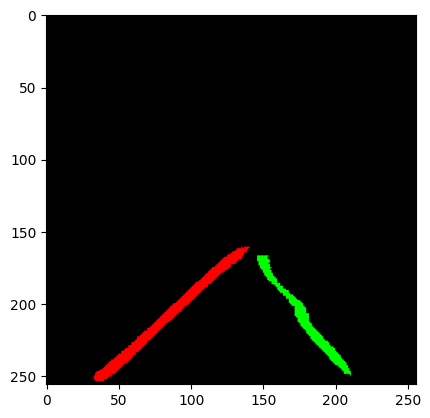

In [ ]:
# Class visualization
out_classification_viz = np.zeros((HEIGHT, WIDTH, 3))

for i, lane_index in index_map.items():
    if classes[i] == 0: # Continuous
        color = (255, 0, 0)
    elif classes[i] == 1: # Dashed
        color = (0, 255, 0)
    elif classes[i] == 2: # Double-dashed
        color = (0, 0, 255)
    else:
        raise
    out_classification_viz[out_segmentation_np == lane_index] = color

imshow(out_classification_viz.astype(np.uint8))
